In [1]:
import pandas as pd
import os
DATA_DIR = "~/Desktop/code/data/"

data_df = pd.read_csv(os.path.join(DATA_DIR, "ec-taxa-media-overlap.csv"), low_memory=False)

filter = data_df["ec"].str.contains("-")
data_df = data_df[~filter]

data_df = data_df[["taxon_id", "media_id", "ec"]]\
    .value_counts()\
    .reset_index()

data_df = data_df.pivot(
    index=["taxon_id", "media_id"],
    columns="ec",
    values="count"
)
data_df = data_df.fillna(0.0).reset_index()
data_df.head()

ec,taxon_id,media_id,1.1.1.1,1.1.1.103,1.1.1.11,1.1.1.119,1.1.1.14,1.1.1.18,1.1.1.2,1.1.1.22,...,3.5.2.10,3.5.2.6,3.5.3.1,3.5.3.3,3.5.5.1,4.1.1.73,4.2.1.32,4.4.1.1,6.2.1.57,6.3.1.20
0,1004166,1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1004261,J181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1004261,J455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1005925,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1005926,J118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## UMAP

### UMAP fit, default = 2 dimensions

In [2]:
import umap

data = data_df.drop(["taxon_id","media_id"], axis=1).copy()
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

embedding.shape

(7220, 2)

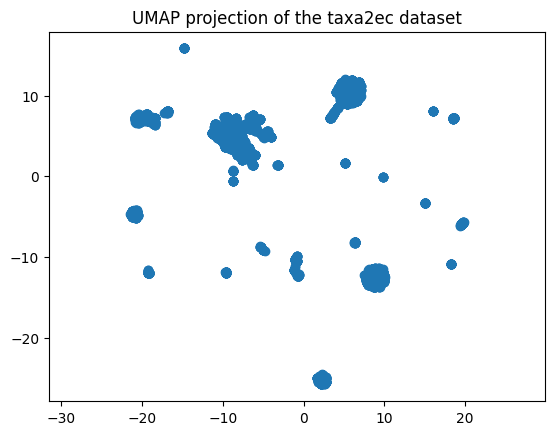

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.scatter(
    embedding[:, 0],
    embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the taxa2ec dataset', fontsize=12);

### Splitting into training and test sets

In [4]:
TARGET_VAR = "taxon_id"
RANDOM_SEED = 666
UMAP_METRIC = "euclidean"
UMAP_SEED = 42

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_df.drop(["taxon_id", "media_id"], axis=1),
    data_df[TARGET_VAR],
    test_size=0.2,
    random_state=RANDOM_SEED
)

### 2-dimensions

In [6]:
reducer2 = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=2, # 4 components allows us to easily visualize in 3 dimensions, can reduce to 2-3
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_2 = reducer2.fit_transform(X_train)
reduced_2 = pd.DataFrame(
    reduced_2,
    columns=[f"Component {i+1}" for i in range(reduced_2.shape[1])]
)
reduced_2.head()

,Component 1,Component 2
0,7.850257,-22.078093
1,-10.902859,27.757227
2,13.023886,28.380087
3,-37.292294,-29.893616
4,-24.882750,-7.377253


In [7]:
import numpy as np
import pandas as pd
from umap import UMAP
import matplotlib.pyplot as plt
import hdbscan

# Load your dataset
data2 = reduced_2.copy()

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10, gen_min_span_tree=True, prediction_data=True) # cluster_selection_method="leaf", 
clusters = clusterer.fit_predict(data2)

# Add the cluster labels to the data
data2['Cluster'] = clusters

# Add ID columns
data2[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

#data.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
print(clusterer.labels_.max(), "clusters")
data2.head()

133 clusters


,Component 1,Component 2,Cluster,taxon_id,media_id
0,7.850257,-22.078093,30,103836,J104
1,-10.902859,27.757227,8,76637,J28
2,13.023886,28.380087,0,589240,J104
3,-37.292294,-29.893616,-1,1036778,1a
4,-24.882750,-7.377253,23,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


In [8]:
filtered_2 = data2[data2['Cluster'] >= 0]

In [9]:
import plotly.express as px

fig = px.scatter(
    data_frame=filtered_2,
    x="Component 1",
    y="Component 2",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=["taxon_id", "media_id"],
    template="plotly_white"
)
fig.show()

#### Predict

,media_id,species,taxon_id,source,ec
0,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.3
1,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.3
2,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.22
3,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.22
4,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.23


### 3-dimensions

In [10]:
reducer3 = umap.UMAP(
    metric=UMAP_METRIC,
    n_components=3, # 4 components allows us to easily visualize in 3 dimensions, can reduce to 2-3
    n_epochs=5000,
    random_state=UMAP_SEED,
    n_jobs=1
)

reduced_3 = reducer3.fit_transform(X_train)
reduced_3 = pd.DataFrame(
    reduced_3,
    columns=[f"Component {i+1}" for i in range(reduced_3.shape[1])]
)
reduced_3.head()

,Component 1,Component 2,Component 3
0,17.655842,15.653206,-0.532637
1,-6.506586,27.462242,4.035050
2,25.284380,-22.777060,-7.032813
3,57.161827,14.121233,54.820942
4,46.738594,19.594370,39.020985


In [11]:
# Load your dataset
data3 = reduced_3.copy()

# HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_samples=5, min_cluster_size=10, gen_min_span_tree=True, prediction_data=True) # cluster_selection_method="leaf", 
clusters = clusterer.fit_predict(data3)

# Add the cluster labels to the data
data3['Cluster'] = clusters

# Add ID columns
data3[["taxon_id", "media_id"]] = data_df.loc[X_train.index, ["taxon_id", "media_id"]].values

#data.to_csv(os.path.join(DATA_DIR, "taxa-model.csv"), index=False)
print(clusterer.labels_.max(), "clusters")
data3.head()

172 clusters


,Component 1,Component 2,Component 3,Cluster,taxon_id,media_id
0,17.655842,15.653206,-0.532637,135,103836,J104
1,-6.506586,27.462242,4.035050,2,76637,J28
2,25.284380,-22.777060,-7.032813,0,589240,J104
3,57.161827,14.121233,54.820942,16,1036778,1a
4,46.738594,19.594370,39.020985,33,"[{'NCBI tax id': 113557, 'Matching level': 'su...",J84


In [12]:
filtered_3 = data3[data3['Cluster'] >= 0]

In [13]:
import plotly.express as px

fig = px.scatter_3d(
    data_frame=filtered_3,
    x="Component 1",
    y="Component 2",
    z="Component 3",
    color="Cluster",
    color_discrete_sequence=px.colors.qualitative.Pastel,
    hover_data=["taxon_id", "media_id"],
    template="plotly_white"
)
fig.update_traces(marker={'size': 5})
fig.show()

<Axes: ylabel='$\\lambda$ value'>

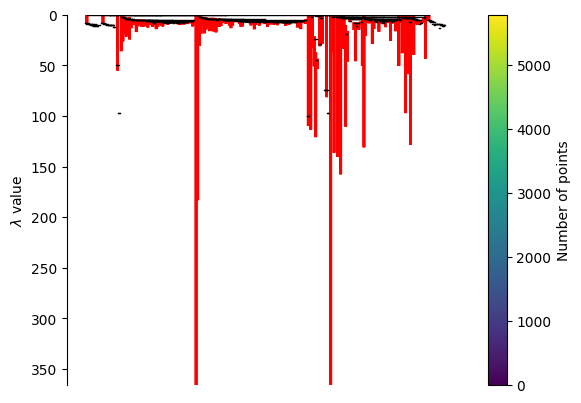

In [14]:
#clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=40, edge_linewidth=2)
#clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

C:\Users\jakel\AppData\Local\Temp\ipykernel_7432\3693830524.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




<Axes: ylabel='Density'>

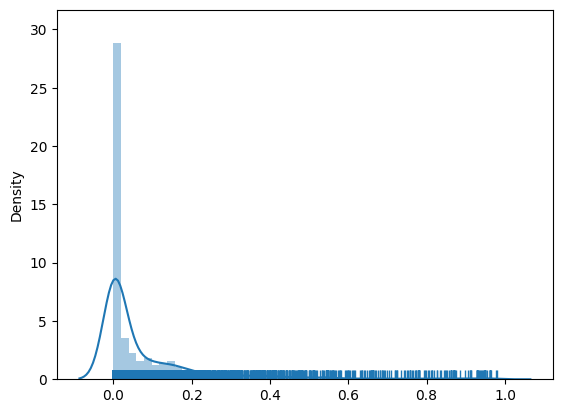

In [15]:
sns.distplot(clusterer.outlier_scores_[np.isfinite(clusterer.outlier_scores_)], rug=True)

In [16]:
threshold = pd.Series(clusterer.outlier_scores_).quantile(0.5)
outliers = np.where(clusterer.outlier_scores_ > threshold)[0]

#plt.scatter(*data.T, s=50, linewidth=0, c='gray', alpha=0.25)
#plt.scatter(*data[outliers].T, s=50, linewidth=0, c='red', alpha=0.5)

#TODO: omit outliers, or label with this threshold data... though this may already happen with cluster = -1?

In [17]:
### generate_prediction_data() with MAGs